# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

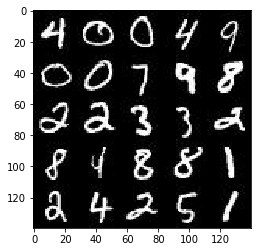

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

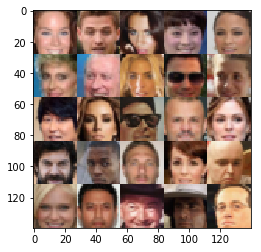

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x1 = tf.maximum(0.2*x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2*x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2*x3, x3)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
   
    with tf.variable_scope('generator', reuse=not is_train):
    
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, 
                                        padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, 
                                        padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2*x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        out = tf.tanh(logits)        

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
     
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*(0.9)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    steps = 0
    n_images = 32
    
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    
    input_real, input_z, l_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
     
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               l_rate: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:    
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8877... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 2.3555... Generator Loss: 2.3039
Epoch 1/2... Discriminator Loss: 1.4728... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.5624... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 0.9148
Epoch 1/2... Discriminator Loss: 1.5773... Generator Loss: 0.5013
Epoch 1/2... Discriminator Loss: 1.6584... Generator Loss: 1.7112
Epoch 1/2... Discriminator Loss: 1.4888... Generator Loss: 0.4785
Epoch 1/2... Discriminator Loss: 1.4564... Generator Loss: 1.2660
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 1.2481


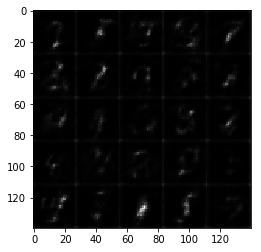

Epoch 1/2... Discriminator Loss: 1.2296... Generator Loss: 1.3221
Epoch 1/2... Discriminator Loss: 1.0830... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 1.1686... Generator Loss: 1.2399
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 0.7367
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 1.0922
Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 1.3342
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 0.9674
Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 1.1060... Generator Loss: 0.8910


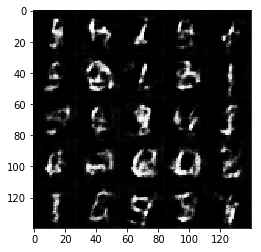

Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 1.8172
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.4382
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 0.7176
Epoch 1/2... Discriminator Loss: 1.4699... Generator Loss: 0.4968
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 1.0283
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 1.4279
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 1.2821
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 1.0021
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 1.2831


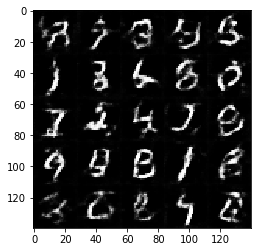

Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.4840
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 0.7241
Epoch 1/2... Discriminator Loss: 1.1242... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 1.0119... Generator Loss: 1.1337
Epoch 1/2... Discriminator Loss: 1.1914... Generator Loss: 0.7117


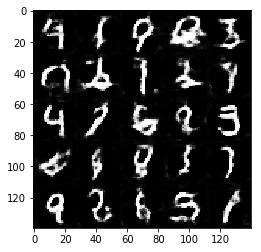

Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.5176
Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 0.4890
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 1.5158
Epoch 1/2... Discriminator Loss: 1.0445... Generator Loss: 0.9757
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 0.6786
Epoch 1/2... Discriminator Loss: 1.3091... Generator Loss: 0.5962
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.6992
Epoch 1/2... Discriminator Loss: 1.0511... Generator Loss: 0.9373


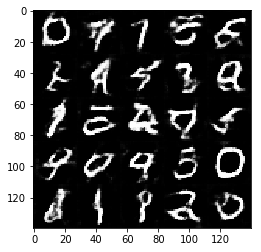

Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 0.6075
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 1.5515... Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 0.9646
Epoch 1/2... Discriminator Loss: 0.9504... Generator Loss: 1.0480
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 1.0704
Epoch 1/2... Discriminator Loss: 0.8454... Generator Loss: 1.3602
Epoch 1/2... Discriminator Loss: 1.1530... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 1.5034


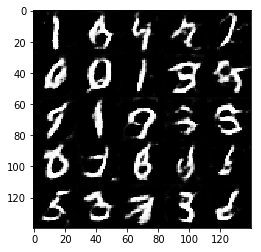

Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.5521
Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 1.0888
Epoch 1/2... Discriminator Loss: 0.9610... Generator Loss: 0.9556
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.5412
Epoch 1/2... Discriminator Loss: 0.8919... Generator Loss: 1.4020
Epoch 1/2... Discriminator Loss: 1.2274... Generator Loss: 0.6585
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.7088
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 0.9759
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.0072
Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 1.1700


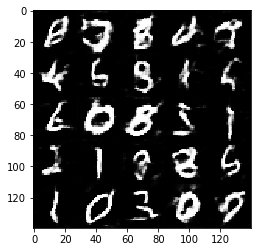

Epoch 1/2... Discriminator Loss: 2.1130... Generator Loss: 0.2630
Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 0.7888
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 1.3496
Epoch 1/2... Discriminator Loss: 0.9722... Generator Loss: 1.0485
Epoch 1/2... Discriminator Loss: 0.8484... Generator Loss: 1.3178
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.4991
Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.4207
Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 0.5684
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 1.1714
Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 0.8244


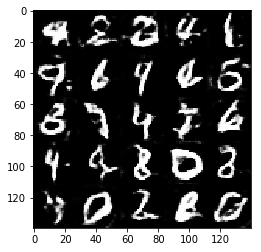

Epoch 1/2... Discriminator Loss: 1.3161... Generator Loss: 1.6944
Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 1.3662
Epoch 1/2... Discriminator Loss: 1.1776... Generator Loss: 0.7875
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 0.6042
Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 0.9546
Epoch 1/2... Discriminator Loss: 1.0074... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.6571... Generator Loss: 2.8844
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 1.6359
Epoch 1/2... Discriminator Loss: 0.9720... Generator Loss: 0.9112
Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 0.7977


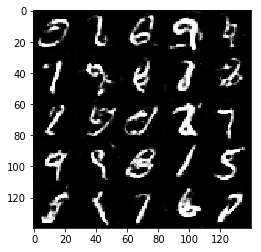

Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 0.8146... Generator Loss: 1.4788
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 1.1504
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.5846
Epoch 2/2... Discriminator Loss: 1.0920... Generator Loss: 1.6327
Epoch 2/2... Discriminator Loss: 1.1716... Generator Loss: 1.8921
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 1.7581
Epoch 2/2... Discriminator Loss: 0.9647... Generator Loss: 1.0743
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 1.4424


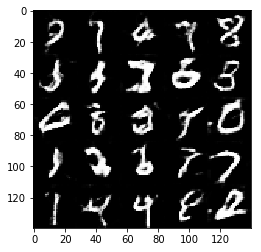

Epoch 2/2... Discriminator Loss: 1.2630... Generator Loss: 0.7335
Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 1.3377
Epoch 2/2... Discriminator Loss: 0.8168... Generator Loss: 1.5404
Epoch 2/2... Discriminator Loss: 0.8951... Generator Loss: 1.7105
Epoch 2/2... Discriminator Loss: 0.7962... Generator Loss: 1.2590
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 1.3269
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 1.1161
Epoch 2/2... Discriminator Loss: 1.0045... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 1.7017
Epoch 2/2... Discriminator Loss: 0.7700... Generator Loss: 1.2959


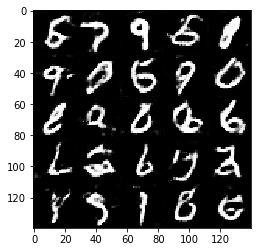

Epoch 2/2... Discriminator Loss: 0.9289... Generator Loss: 1.1317
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 0.8633
Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.6597
Epoch 2/2... Discriminator Loss: 1.5250... Generator Loss: 0.4664
Epoch 2/2... Discriminator Loss: 0.8143... Generator Loss: 1.3368
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 0.9632
Epoch 2/2... Discriminator Loss: 0.8121... Generator Loss: 2.0270
Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 1.0726
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 1.0824


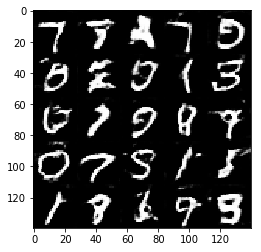

Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 1.5684
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 1.2072
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.4411
Epoch 2/2... Discriminator Loss: 1.9187... Generator Loss: 3.1867
Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 1.2770
Epoch 2/2... Discriminator Loss: 1.0245... Generator Loss: 1.1729
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 1.0910
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 1.5183


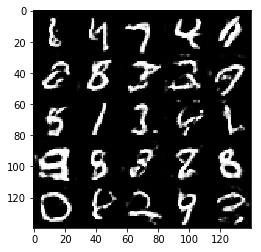

Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.3270
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 1.3914
Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.5780
Epoch 2/2... Discriminator Loss: 0.7282... Generator Loss: 2.4344
Epoch 2/2... Discriminator Loss: 1.4352... Generator Loss: 0.5775
Epoch 2/2... Discriminator Loss: 0.8203... Generator Loss: 1.1452
Epoch 2/2... Discriminator Loss: 0.6470... Generator Loss: 1.8312
Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 0.6857
Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 1.0965
Epoch 2/2... Discriminator Loss: 0.5499... Generator Loss: 2.1213


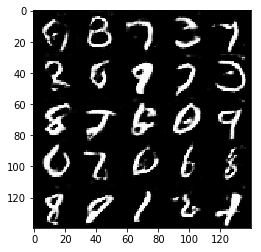

Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.2593
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 0.9918
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.1873
Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 1.5211
Epoch 2/2... Discriminator Loss: 0.8294... Generator Loss: 1.1137
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 1.9062
Epoch 2/2... Discriminator Loss: 0.4819... Generator Loss: 2.3083
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 0.7846
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 3.1010
Epoch 2/2... Discriminator Loss: 0.8637... Generator Loss: 2.5035


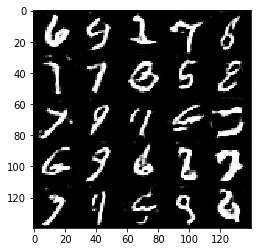

Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 1.9821
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.1159
Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 1.3875
Epoch 2/2... Discriminator Loss: 0.8185... Generator Loss: 2.0255
Epoch 2/2... Discriminator Loss: 0.6922... Generator Loss: 1.8081
Epoch 2/2... Discriminator Loss: 0.9312... Generator Loss: 1.1050
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 1.1162
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 2.0031
Epoch 2/2... Discriminator Loss: 1.0993... Generator Loss: 2.1797
Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 0.6966


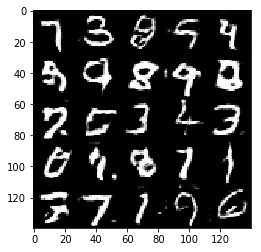

Epoch 2/2... Discriminator Loss: 0.5658... Generator Loss: 2.1810
Epoch 2/2... Discriminator Loss: 0.7011... Generator Loss: 1.7594
Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 1.6432
Epoch 2/2... Discriminator Loss: 2.5255... Generator Loss: 3.4589
Epoch 2/2... Discriminator Loss: 1.1666... Generator Loss: 2.0734
Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 0.9183
Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 1.1564
Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 1.4682
Epoch 2/2... Discriminator Loss: 0.9112... Generator Loss: 1.0225
Epoch 2/2... Discriminator Loss: 0.9283... Generator Loss: 1.0544


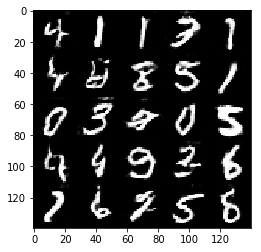

Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.8670
Epoch 2/2... Discriminator Loss: 0.6217... Generator Loss: 1.6546
Epoch 2/2... Discriminator Loss: 1.5483... Generator Loss: 0.5848
Epoch 2/2... Discriminator Loss: 0.8573... Generator Loss: 1.9435
Epoch 2/2... Discriminator Loss: 0.8209... Generator Loss: 1.5830
Epoch 2/2... Discriminator Loss: 0.7685... Generator Loss: 1.3447
Epoch 2/2... Discriminator Loss: 0.8808... Generator Loss: 2.0973
Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 1.0731
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 0.6814... Generator Loss: 1.5092


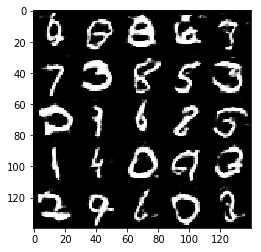

Epoch 2/2... Discriminator Loss: 0.9029... Generator Loss: 1.8314
Epoch 2/2... Discriminator Loss: 0.8971... Generator Loss: 1.1356
Epoch 2/2... Discriminator Loss: 0.8444... Generator Loss: 1.1754
Epoch 2/2... Discriminator Loss: 0.9221... Generator Loss: 1.0104
Epoch 2/2... Discriminator Loss: 0.8470... Generator Loss: 1.0780
Epoch 2/2... Discriminator Loss: 0.6762... Generator Loss: 1.6837
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 2.1403


In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 2.6084
Epoch 1/1... Discriminator Loss: 3.1316... Generator Loss: 0.1260
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.7000... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.7549
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 1.7209
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 3.2242
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 2.6891
Epoch 1/1... Discriminator Loss: 1.8480... Generator Loss: 0.4380
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6905


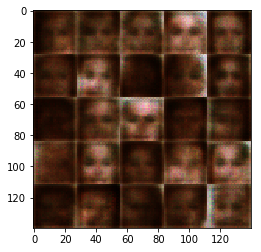

Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.0393
Epoch 1/1... Discriminator Loss: 1.9849... Generator Loss: 0.2522
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.9094... Generator Loss: 0.2694
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 1.2034


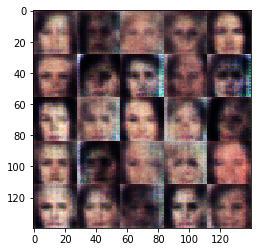

Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 1.8414
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.5752
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.6229... Generator Loss: 1.4395
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.7830


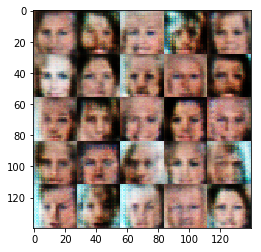

Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 1.4403
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.7785... Generator Loss: 0.3520
Epoch 1/1... Discriminator Loss: 1.7656... Generator Loss: 2.1011
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 1.6653... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.4865
Epoch 1/1... Discriminator Loss: 1.8426... Generator Loss: 0.3168


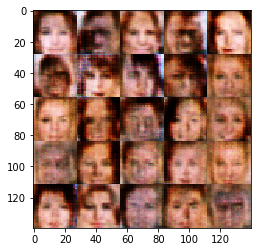

Epoch 1/1... Discriminator Loss: 1.7550... Generator Loss: 0.3223
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.8012... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.8263


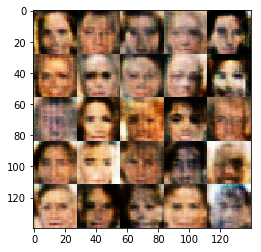

Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 1.5337
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.1937


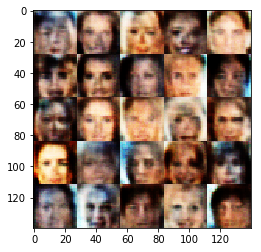

Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8617


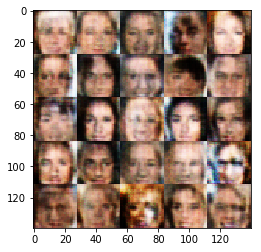

Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.6490
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 1.4580


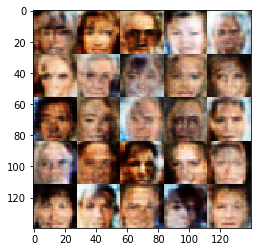

Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 1.1024


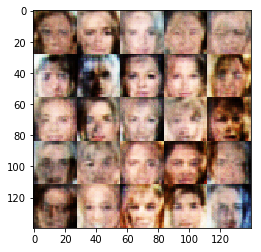

Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.2818
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 1.4338
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8012


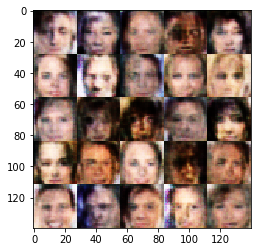

Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7214


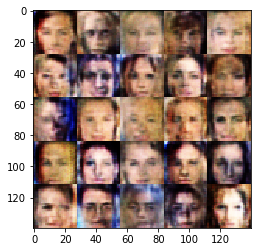

Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.3633
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.8302


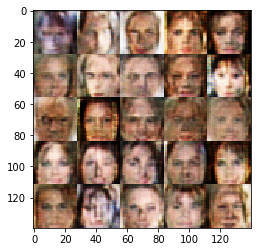

Epoch 1/1... Discriminator Loss: 2.1972... Generator Loss: 0.1887
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 1.2797
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 2.1780... Generator Loss: 0.2062
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.6811


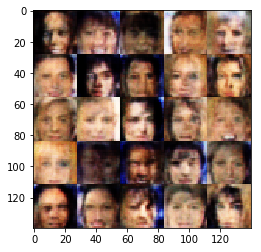

Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7598


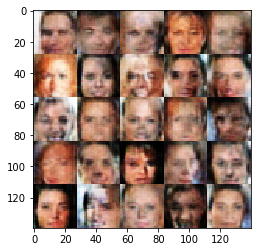

Epoch 1/1... Discriminator Loss: 1.6845... Generator Loss: 1.8669
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 1.0008


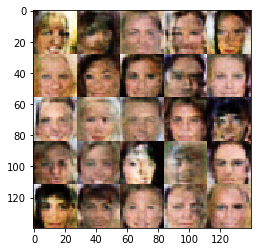

Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.7401


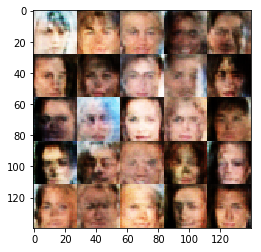

Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.6036... Generator Loss: 0.4434
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.8854


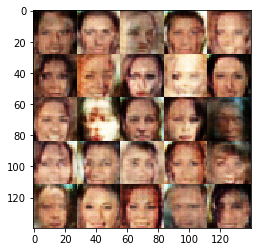

Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.5716


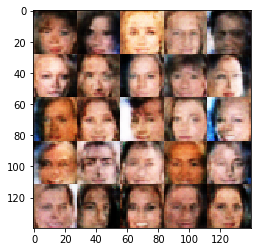

Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.8655


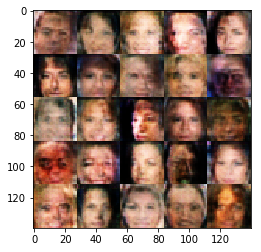

Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.8351


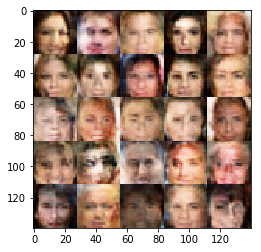

Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 1.1741
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 1.2463
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6844


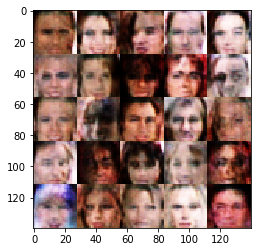

Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.9570


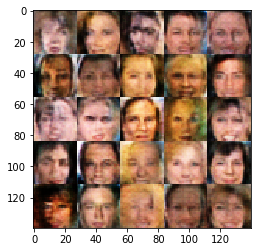

Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.8939


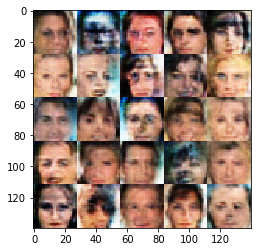

Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 1.5908
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.9486


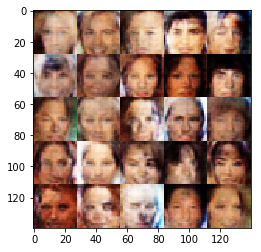

Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7617


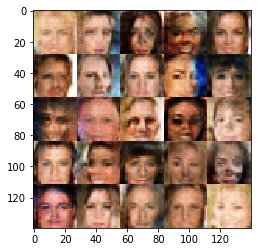

Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.6196... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 1.4452
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.8927


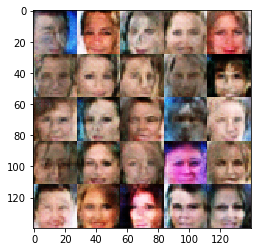

Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.8406


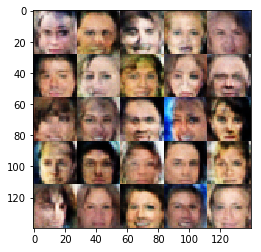

Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 1.2897
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.3272


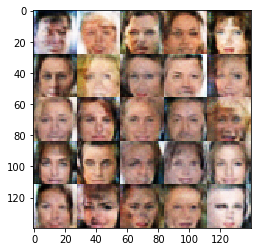

Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.3911
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.6329


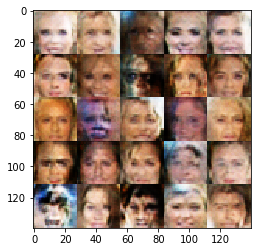

Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.5501


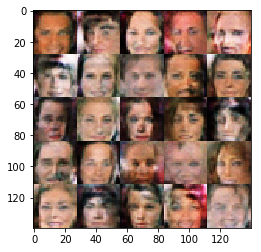

Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 1.1845
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6397


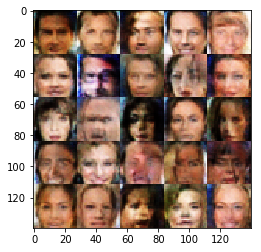

Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.9370


In [17]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.